In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from shapely.geometry import Polygon, Point
import sys
import os
import statistics
import psutil
import copy
import pickle
import re
from abc import ABC, abstractmethod
import math
import copy
import xml.etree.ElementTree as ET
import gc
from copy import deepcopy
from pathlib import Path
from skimage import data
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import skimage
import PIL
from skimage.filters import threshold_otsu
import torchvision.models as torchmodels
import openslide
import torch.utils.data
import torchvision
import torch.nn as nn
list_pathstoadd = ["Src/",
                   "../PyDmed/"]
#check if PyDmed is in path -------
if(os.path.isdir(list_pathstoadd[-1]) == False):
    raise Exception(
            "Could not find PyDmed in path: {}.\n".format(
                    list_pathstoadd[-1]
                )+\
            "Please either add PyDmed to {}, or add the correct path to ".format(
                    list_pathstoadd[-1]
                )+\
            "the end of the above list `list_pathstoadd`."
        )
for path in list_pathstoadd:
    if(path not in sys.path):
        sys.path.append(path)
import pydmed
from pydmed.utils.data import *
import pydmed.lightdl
from pydmed.lightdl import *
import pydmed.stat
from pydmed.stat import *
import pydmed.extensions.dl
import projutils.datasets
import relatedwork
from relatedwork.utils.generativemodels import ResidualEncoder
import model
from model import *
import warwickher2

In [2]:
#SETTINGS ================
idx_split = 3
flag_use_annotregions = False
random_seed = 15
num_visualwords = 10
batchsize = 32
stepsize_gradupdate = 20
num_warmup_droppedpatches = 400
scale_thumbnail = 0.005
#debugflags =====
flag_verbose_perwsiavg = False
nb_rootdir = "./"
random.seed(random_seed)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Make Dataset and Dataloaders

In [4]:
#build datasets ==============================================
#make the dataset ======
rootpath = "/media/user1/D870247070245810/AkFiles/Data/Warwick_HER2_Contest/Train/Training"
idx_dataset = 0
name_dataset = "warwickher2"
#read the labels
dict_case_to_labels = {}
with open(os.path.join(rootpath, "groundTruth.csv"), 'r') as csvfile:
    lines = csvfile.readlines() 
    for line in lines:
        case, label1, label2 = line.split(",")
#         print("case={},      label1={},     label2={}"\
#              .format(case, label1, label2))
        dict_case_to_labels[int(case)] = [int(label1), int(label2)]
list_path = []
for u in os.listdir(rootpath):
    if(os.path.isdir( os.path.join(rootpath, u))):
        list_path.append(u)
list_path.sort()
list_patients = []
for idx_patient, path in enumerate(list_path):
    fname_HandE = str(path) + "_HE.ndpi"
    fname_Her2 = str(path) + "_HER2.ndpi"
    fname_xml = str(path) + "_HER2.xml"
    labels = dict_case_to_labels[int(path)]
    new_patient = pydmed.utils.data.Patient(
                    int_uniqueid = idx_patient*1000 + idx_dataset,\
                    dict_records = {
                        "WSI_HandE":pydmed.utils.data.Record(
                                rootpath,
                                os.path.join(path, fname_HandE),\
                                {"type":"HandE"}
                              ),
                        "WSI_Her2":pydmed.utils.data.Record(
                                rootpath,
                                os.path.join(path, fname_Her2),\
                                {"type":"Her2"}
                              ),
                        "XML_Her2":pydmed.utils.data.Record(
                                rootpath,
                                os.path.join(path, fname_xml),\
                                {"type":"asap-xml"}
                              ),
                         "Her2score":labels[0],
                         "percentageof_complete_membrane":labels[1]
                        }
                     )
    list_patients.append(new_patient)
#make the dataset =========
dataset = pydmed.utils.data.Dataset("warwickher2", list_patients)
def func_getlabel_of_patient(patient):
    return patient.dict_records["Her2score"]
list_allpatients = [patient for patient in dataset.list_patients]
#presave paths to the foreground masks for the splits ====
for patient in list_allpatients:
    try:
        fname_Her2 = os.path.join( 
            patient.dict_records["WSI_Her2"].rootdir,
            patient.dict_records["WSI_Her2"].relativedir
        )
        fname_xml = os.path.join( 
            patient.dict_records["XML_Her2"].rootdir,
            patient.dict_records["XML_Her2"].relativedir
        )
        np_foreground = projutils.asap.get_foreground_from_polyg(
                fname_wsi = fname_Her2,\
                fname_xml = fname_xml,\
                scale = scale_thumbnail
               )
        patient.dict_records["precomputed_polyongmask"] = np_foreground
    except Exception as e:
        print("failed.-------------")
        print(fname_Her2)
        print(fname_xml)
        print("------\n\n\n\n")
        print(str(e))
#precompute foreground masks and polygonmasks ===========
tstart_otsu = time.time()
dict_patient_to_foreground = {}
for idx_patient, patient in enumerate(list_allpatients):
    print(" computing foreground for patient {}".format(idx_patient))
    fname_wsi = os.path.join(patient.dict_records["WSI_Her2"].rootdir,\
                             patient.dict_records["WSI_Her2"].relativedir)
    patient_foreground_mask =\
        warwickher2.otsu_get_foregroundmask(fname_wsi, scale_thumbnail)
    patient.dict_records["precomputed_otsu"] = patient_foreground_mask
    patient.dict_records["scale_thumbnail"] = scale_thumbnail
tend_otsu = time.time()
print("elapsed time = {}".format(tend_otsu - tstart_otsu))            


train_ds, val_ds, test_ds =\
                    pydmed.utils.data.Dataset.labelbalanced_splits_from(
                        dataset=dataset,
                        percentage_partitions=[60, 0, 40],\
                        func_getlabel_of_patient = func_getlabel_of_patient,
                        verbose=False
                     )
#make dataloaders  =========================
tfms = torchvision.transforms.ToTensor()
const_global_info = {
    "mode_trainortest":"train",
    "width_bigchunk":2000,
    "heigth_bigchunk":2000,
    "width_smallchunk":224,
    "heigth_smallchunk":224,
    "num_bigchunkloaders":10,
    "maxlength_queue_smallchunk":100,
    "maxlength_queue_lightdl":200,
    "interval_resched": 5,
    "core-assignment":{"lightdl":None,
                       "smallchunkloaders":None,
                       "bigchunkloaders":None}
}

train_dl = pydmed.extensions.dl.LabelBalancedDL(
                  func_getlabel_of_patient = func_getlabel_of_patient,\
                  dataset=train_ds,\
                  type_bigchunkloader=warwickher2.WSIRandomBigchunkLoader,\
                  type_smallchunkcollector=warwickher2.WSIRandomSmallchunkCollector,\
                  const_global_info=const_global_info,\
                  batch_size=batchsize, tfms=tfms, fname_logfile=None,
                  flag_grabqueue_onunsched = False
                 )
#print train_ds and test_ds information =============
print("\n\n\ntraining split =====================")
for idx_patient, patient in enumerate(train_ds.list_patients):
    print("train_ds[{}] = {}".format(
                 idx_patient, patient.dict_records["WSI_Her2"].relativedir
                )
       )
print("\n\n\n\n\ntesting split =====================")
for idx_patient, patient in enumerate(test_ds.list_patients):
    print("test_ds[{}] = {}".format(
                 idx_patient, patient.dict_records["WSI_Her2"].relativedir
                )
       )

annotation 0
[['0.83917582' '0.83917582']
 ['2.47432971' '45821.8359']
 ['49150.2969' '45822.3203']
 ['49150.5078' '1.11171949']]




annotation 0
[['57066.3086' '9.72302914']
 ['57190.4336' '56312.9844']
 ['192507.141' '56315.4258']
 ['190943.016' '41.8897438']]




annotation 0
[['71001.0312' '46.911541']
 ['71157.3906' '50931.6445']
 ['151544.5' '50933.3477']
 ['151549.938' '2.52269983']]




annotation 0
[['45580.75' '192.161682']
 ['45896.9219' '57073.5859']
 ['143357.219' '57085.2305']
 ['143356.844' '3.78194118']]




annotation 0
[['63455.7773' '494.093933']
 ['63526.3594' '48280.0352']
 ['134887.641' '48350.6172']
 ['134887.641' '282.339386']]




annotation 0
[['81834.2109' '708.521301']
 ['82568.3984' '42762.3047']
 ['139256.359' '42996.8906']
 ['139260.688' '3.19335246']]




annotation 0
[['54301.6406' '8.42716503']
 ['55424.4492' '58611.2383']
 ['118773.539' '58607']
 ['118781.008' '3.34055328']]




annotation 0
[['61620.6523' '459.284363']
 ['61737.1367' '46075.6016']
 

 computing foreground for patient 39
 computing foreground for patient 40
 computing foreground for patient 41
 computing foreground for patient 42
 computing foreground for patient 43
 computing foreground for patient 44
 computing foreground for patient 45
 computing foreground for patient 46
 computing foreground for patient 47
 computing foreground for patient 48
 computing foreground for patient 49
 computing foreground for patient 50
 computing foreground for patient 51
elapsed time = 1.0670297145843506



training split =====================
train_ds[0] = 39/39_HER2.ndpi
train_ds[1] = 57/57_HER2.ndpi
train_ds[2] = 46/46_HER2.ndpi
train_ds[3] = 70/70_HER2.ndpi
train_ds[4] = 13/13_HER2.ndpi
train_ds[5] = 52/52_HER2.ndpi
train_ds[6] = 68/68_HER2.ndpi
train_ds[7] = 16/16_HER2.ndpi
train_ds[8] = 12/12_HER2.ndpi
train_ds[9] = 86/86_HER2.ndpi
train_ds[10] = 58/58_HER2.ndpi
train_ds[11] = 79/79_HER2.ndpi
train_ds[12] = 14/14_HER2.ndpi
train_ds[13] = 15/15_HER2.ndpi
train_ds[14] = 74/74_

# Traing a Model

In [5]:
#build the model and optimizer====================
model = model.Pipeline1(num_classes=4, num_visualwords=num_visualwords,\
                        device_stg3=device, size_input=[batchsize,3,224,224]) 
optimizer = torch.optim.Adam(model.parameters(), lr=0.000005)
criterion = nn.CrossEntropyLoss(
                    weight=torch.from_numpy(np.array([1.0,1.0,1.0,1.0]))
                ).to(device).float()
model.to(device)
print("")

In [6]:
#train the model ============================
if('history_trainingloss' not in globals()):
    history_trainingloss = []
    history_testloss = []
    history_fed_labels = []
    list_seenbatches = []
train_dl.start()
time.sleep(30)
print("========== pid of the root process = {} ============".format(os.getpid()))
model.train()
tstart = time.time()
batchcount = 0
optimizer.zero_grad()
while True:
    #get x and y =========
    x, list_patients, list_smallchunks = train_dl.get()
    list_seenbatches.append(list_patients)
    tensor_list_assignmentindices, list_different_groups =\
                getassignment_img_to_wsi(x, list_patients, list_smallchunks)
    y = [func_getlabel_of_patient(patient)\
         for patient in list_different_groups]
    train_dl.list_smallchunksforvis = [] #to avoid memory leak in long run.
    batchcount += 1
    #training step =========
    if((batchcount%10) == 0):
        print(" batchcount {}".format(batchcount))
    if(batchcount < num_warmup_droppedpatches):
        print("    the batch dropped (warm-up).")
        continue
    assert(batchcount >= num_warmup_droppedpatches)
        
    history_fed_labels = history_fed_labels + y
    y = torch.from_numpy(np.array(y))
    netout = model(x.to(device),\
                   tensor_list_assignmentindices.to(device))[:,:,0,0] #[numgroups x 2]
    loss = criterion(netout, y.cuda())/(stepsize_gradupdate+0.0)
    loss.backward()
    if((batchcount%stepsize_gradupdate)==0):
        optimizer.step()
        optimizer.zero_grad()
    history_trainingloss.append(loss.detach().cpu().numpy())
    if(batchcount > 8*10000 + num_warmup_droppedpatches):
        train_dl.pause_loading()
#         test_dl.pause_loading()
        break
print("elpased time = {} seconds".format(time.time()-tstart))

 loading initial bigchunks, please wait ....
     bigchunk 0 from 10, please wait ...

     bigchunk 1 from 10, please wait ...

     bigchunk 2 from 10, please wait ...

     bigchunk 3 from 10, please wait ...

     bigchunk 4 from 10, please wait ...

     bigchunk 5 from 10, please wait ...

     bigchunk 6 from 10, please wait ...

     bigchunk 7 from 10, please wait ...

     bigchunk 8 from 10, please wait ...

========== pid of the root process = 5577 ============
     bigchunk 9 from 10, please wait ...

The initial loading of bigchunks took 39.530198097229004 seconds.
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
 batchcount 10
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
   

    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
 batchcount 230
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
 batchcount 240
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
    the batch dropped (warm-up).
 batchcount 250
    the batch dropped (warm-

 batchcount 1640
 batchcount 1650
 batchcount 1660
 batchcount 1670
 batchcount 1680
 batchcount 1690
 batchcount 1700
 batchcount 1710
 batchcount 1720
 batchcount 1730
 batchcount 1740
 batchcount 1750
 batchcount 1760
 batchcount 1770
 batchcount 1780
 batchcount 1790
 batchcount 1800
 batchcount 1810
 batchcount 1820
 batchcount 1830
 batchcount 1840
 batchcount 1850
 batchcount 1860
 batchcount 1870
 batchcount 1880
 batchcount 1890
 batchcount 1900
 batchcount 1910
 batchcount 1920
 batchcount 1930
 batchcount 1940
 batchcount 1950
 batchcount 1960
 batchcount 1970
 batchcount 1980
 batchcount 1990
 batchcount 2000
 batchcount 2010
 batchcount 2020
 batchcount 2030
 batchcount 2040
 batchcount 2050
 batchcount 2060
 batchcount 2070
 batchcount 2080
 batchcount 2090
 batchcount 2100
 batchcount 2110
 batchcount 2120
 batchcount 2130
 batchcount 2140
 batchcount 2150
 batchcount 2160
 batchcount 2170
 batchcount 2180
 batchcount 2190
 batchcount 2200
 batchcount 2210
 batchcount 22

 batchcount 6460
 batchcount 6470
 batchcount 6480
 batchcount 6490
 batchcount 6500
 batchcount 6510
 batchcount 6520
 batchcount 6530
 batchcount 6540
 batchcount 6550
 batchcount 6560
 batchcount 6570
 batchcount 6580
 batchcount 6590
 batchcount 6600
 batchcount 6610
 batchcount 6620
 batchcount 6630
 batchcount 6640
 batchcount 6650
 batchcount 6660
 batchcount 6670
 batchcount 6680
 batchcount 6690
 batchcount 6700
 batchcount 6710
 batchcount 6720
 batchcount 6730
 batchcount 6740
 batchcount 6750
 batchcount 6760
 batchcount 6770
 batchcount 6780
 batchcount 6790
 batchcount 6800
 batchcount 6810
 batchcount 6820
 batchcount 6830
 batchcount 6840
 batchcount 6850
 batchcount 6860
 batchcount 6870
 batchcount 6880
 batchcount 6890
 batchcount 6900
 batchcount 6910
 batchcount 6920
 batchcount 6930
 batchcount 6940
 batchcount 6950
 batchcount 6960
 batchcount 6970
 batchcount 6980
 batchcount 6990
 batchcount 7000
 batchcount 7010
 batchcount 7020
 batchcount 7030
 batchcount 70

 batchcount 11210
 batchcount 11220
 batchcount 11230
 batchcount 11240
 batchcount 11250
 batchcount 11260
 batchcount 11270
 batchcount 11280
 batchcount 11290
 batchcount 11300
 batchcount 11310
 batchcount 11320
 batchcount 11330
 batchcount 11340
 batchcount 11350
 batchcount 11360
 batchcount 11370
 batchcount 11380
 batchcount 11390
 batchcount 11400
 batchcount 11410
 batchcount 11420
 batchcount 11430
 batchcount 11440
 batchcount 11450
 batchcount 11460
 batchcount 11470
 batchcount 11480
 batchcount 11490
 batchcount 11500
 batchcount 11510
 batchcount 11520
 batchcount 11530
 batchcount 11540
 batchcount 11550
 batchcount 11560
 batchcount 11570
 batchcount 11580
 batchcount 11590
 batchcount 11600
 batchcount 11610
 batchcount 11620
 batchcount 11630
 batchcount 11640
 batchcount 11650
 batchcount 11660
 batchcount 11670
 batchcount 11680
 batchcount 11690
 batchcount 11700
 batchcount 11710
 batchcount 11720
 batchcount 11730
 batchcount 11740
 batchcount 11750
 batchcoun

 batchcount 15770
 batchcount 15780
 batchcount 15790
 batchcount 15800
 batchcount 15810
 batchcount 15820
 batchcount 15830
 batchcount 15840
 batchcount 15850
 batchcount 15860
 batchcount 15870
 batchcount 15880
 batchcount 15890
 batchcount 15900
 batchcount 15910
 batchcount 15920
 batchcount 15930
 batchcount 15940
 batchcount 15950
 batchcount 15960
 batchcount 15970
 batchcount 15980
 batchcount 15990
 batchcount 16000
 batchcount 16010
 batchcount 16020
 batchcount 16030
 batchcount 16040
 batchcount 16050
 batchcount 16060
 batchcount 16070
 batchcount 16080
 batchcount 16090
 batchcount 16100
 batchcount 16110
 batchcount 16120
 batchcount 16130
 batchcount 16140
 batchcount 16150
 batchcount 16160
 batchcount 16170
 batchcount 16180
 batchcount 16190
 batchcount 16200
 batchcount 16210
 batchcount 16220
 batchcount 16230
 batchcount 16240
 batchcount 16250
 batchcount 16260
 batchcount 16270
 batchcount 16280
 batchcount 16290
 batchcount 16300
 batchcount 16310
 batchcoun

 batchcount 20330
 batchcount 20340
 batchcount 20350
 batchcount 20360
 batchcount 20370
 batchcount 20380
 batchcount 20390
 batchcount 20400
 batchcount 20410
 batchcount 20420
 batchcount 20430
 batchcount 20440
 batchcount 20450
 batchcount 20460
 batchcount 20470
 batchcount 20480
 batchcount 20490
 batchcount 20500
 batchcount 20510
 batchcount 20520
 batchcount 20530
 batchcount 20540
 batchcount 20550
 batchcount 20560
 batchcount 20570
 batchcount 20580
 batchcount 20590
 batchcount 20600
 batchcount 20610
 batchcount 20620
 batchcount 20630
 batchcount 20640
 batchcount 20650
 batchcount 20660
 batchcount 20670
 batchcount 20680
 batchcount 20690
 batchcount 20700
 batchcount 20710
 batchcount 20720
 batchcount 20730
 batchcount 20740
 batchcount 20750
 batchcount 20760
 batchcount 20770
 batchcount 20780
 batchcount 20790
 batchcount 20800
 batchcount 20810
 batchcount 20820
 batchcount 20830
 batchcount 20840
 batchcount 20850
 batchcount 20860
 batchcount 20870
 batchcoun

 batchcount 24890
 batchcount 24900
 batchcount 24910
 batchcount 24920
 batchcount 24930
 batchcount 24940
 batchcount 24950
 batchcount 24960
 batchcount 24970
 batchcount 24980
 batchcount 24990
 batchcount 25000
 batchcount 25010
 batchcount 25020
 batchcount 25030
 batchcount 25040
 batchcount 25050
 batchcount 25060
 batchcount 25070
 batchcount 25080
 batchcount 25090
 batchcount 25100
 batchcount 25110
 batchcount 25120
 batchcount 25130
 batchcount 25140
 batchcount 25150
 batchcount 25160
 batchcount 25170
 batchcount 25180
 batchcount 25190
 batchcount 25200
 batchcount 25210
 batchcount 25220
 batchcount 25230
 batchcount 25240
 batchcount 25250
 batchcount 25260
 batchcount 25270
 batchcount 25280
 batchcount 25290
 batchcount 25300
 batchcount 25310
 batchcount 25320
 batchcount 25330
 batchcount 25340
 batchcount 25350
 batchcount 25360
 batchcount 25370
 batchcount 25380
 batchcount 25390
 batchcount 25400
 batchcount 25410
 batchcount 25420
 batchcount 25430
 batchcoun

 batchcount 29450
 batchcount 29460
 batchcount 29470
 batchcount 29480
 batchcount 29490
 batchcount 29500
 batchcount 29510
 batchcount 29520
 batchcount 29530
 batchcount 29540
 batchcount 29550
 batchcount 29560
 batchcount 29570
 batchcount 29580
 batchcount 29590
 batchcount 29600
 batchcount 29610
 batchcount 29620
 batchcount 29630
 batchcount 29640
 batchcount 29650
 batchcount 29660
 batchcount 29670
 batchcount 29680
 batchcount 29690
 batchcount 29700
 batchcount 29710
 batchcount 29720
 batchcount 29730
 batchcount 29740
 batchcount 29750
 batchcount 29760
 batchcount 29770
 batchcount 29780
 batchcount 29790
 batchcount 29800
 batchcount 29810
 batchcount 29820
 batchcount 29830
 batchcount 29840
 batchcount 29850
 batchcount 29860
 batchcount 29870
 batchcount 29880
 batchcount 29890
 batchcount 29900
 batchcount 29910
 batchcount 29920
 batchcount 29930
 batchcount 29940
 batchcount 29950
 batchcount 29960
 batchcount 29970
 batchcount 29980
 batchcount 29990
 batchcoun

 batchcount 34010
 batchcount 34020
 batchcount 34030
 batchcount 34040
 batchcount 34050
 batchcount 34060
 batchcount 34070
 batchcount 34080
 batchcount 34090
 batchcount 34100
 batchcount 34110
 batchcount 34120
 batchcount 34130
 batchcount 34140
 batchcount 34150
 batchcount 34160
 batchcount 34170
 batchcount 34180
 batchcount 34190
 batchcount 34200
 batchcount 34210
 batchcount 34220
 batchcount 34230
 batchcount 34240
 batchcount 34250
 batchcount 34260
 batchcount 34270
 batchcount 34280
 batchcount 34290
 batchcount 34300
 batchcount 34310
 batchcount 34320
 batchcount 34330
 batchcount 34340
 batchcount 34350
 batchcount 34360
 batchcount 34370
 batchcount 34380
 batchcount 34390
 batchcount 34400
 batchcount 34410
 batchcount 34420
 batchcount 34430
 batchcount 34440
 batchcount 34450
 batchcount 34460
 batchcount 34470
 batchcount 34480
 batchcount 34490
 batchcount 34500
 batchcount 34510
 batchcount 34520
 batchcount 34530
 batchcount 34540
 batchcount 34550
 batchcoun

 batchcount 38570
 batchcount 38580
 batchcount 38590
 batchcount 38600
 batchcount 38610
 batchcount 38620
 batchcount 38630
 batchcount 38640
 batchcount 38650
 batchcount 38660
 batchcount 38670
 batchcount 38680
 batchcount 38690
 batchcount 38700
 batchcount 38710
 batchcount 38720
 batchcount 38730
 batchcount 38740
 batchcount 38750
 batchcount 38760
 batchcount 38770
 batchcount 38780
 batchcount 38790
 batchcount 38800
 batchcount 38810
 batchcount 38820
 batchcount 38830
 batchcount 38840
 batchcount 38850
 batchcount 38860
 batchcount 38870
 batchcount 38880
 batchcount 38890
 batchcount 38900
 batchcount 38910
 batchcount 38920
 batchcount 38930
 batchcount 38940
 batchcount 38950
 batchcount 38960
 batchcount 38970
 batchcount 38980
 batchcount 38990
 batchcount 39000
 batchcount 39010
 batchcount 39020
 batchcount 39030
 batchcount 39040
 batchcount 39050
 batchcount 39060
 batchcount 39070
 batchcount 39080
 batchcount 39090
 batchcount 39100
 batchcount 39110
 batchcoun

 batchcount 43130
 batchcount 43140
 batchcount 43150
 batchcount 43160
 batchcount 43170
 batchcount 43180
 batchcount 43190
 batchcount 43200
 batchcount 43210
 batchcount 43220
 batchcount 43230
 batchcount 43240
 batchcount 43250
 batchcount 43260
 batchcount 43270
 batchcount 43280
 batchcount 43290
 batchcount 43300
 batchcount 43310
 batchcount 43320
 batchcount 43330
 batchcount 43340
 batchcount 43350
 batchcount 43360
 batchcount 43370
 batchcount 43380
 batchcount 43390
 batchcount 43400
 batchcount 43410
 batchcount 43420
 batchcount 43430
 batchcount 43440
 batchcount 43450
 batchcount 43460
 batchcount 43470
 batchcount 43480
 batchcount 43490
 batchcount 43500
 batchcount 43510
 batchcount 43520
 batchcount 43530
 batchcount 43540
 batchcount 43550
 batchcount 43560
 batchcount 43570
 batchcount 43580
 batchcount 43590
 batchcount 43600
 batchcount 43610
 batchcount 43620
 batchcount 43630
 batchcount 43640
 batchcount 43650
 batchcount 43660
 batchcount 43670
 batchcoun

 batchcount 47690
 batchcount 47700
 batchcount 47710
 batchcount 47720
 batchcount 47730
 batchcount 47740
 batchcount 47750
 batchcount 47760
 batchcount 47770
 batchcount 47780
 batchcount 47790
 batchcount 47800
 batchcount 47810
 batchcount 47820
 batchcount 47830
 batchcount 47840
 batchcount 47850
 batchcount 47860
 batchcount 47870
 batchcount 47880
 batchcount 47890
 batchcount 47900
 batchcount 47910
 batchcount 47920
 batchcount 47930
 batchcount 47940
 batchcount 47950
 batchcount 47960
 batchcount 47970
 batchcount 47980
 batchcount 47990
 batchcount 48000
 batchcount 48010
 batchcount 48020
 batchcount 48030
 batchcount 48040
 batchcount 48050
 batchcount 48060
 batchcount 48070
 batchcount 48080
 batchcount 48090
 batchcount 48100
 batchcount 48110
 batchcount 48120
 batchcount 48130
 batchcount 48140
 batchcount 48150
 batchcount 48160
 batchcount 48170
 batchcount 48180
 batchcount 48190
 batchcount 48200
 batchcount 48210
 batchcount 48220
 batchcount 48230
 batchcoun

 batchcount 52250
 batchcount 52260
 batchcount 52270
 batchcount 52280
 batchcount 52290
 batchcount 52300
 batchcount 52310
 batchcount 52320
 batchcount 52330
 batchcount 52340
 batchcount 52350
 batchcount 52360
 batchcount 52370
 batchcount 52380
 batchcount 52390
 batchcount 52400
 batchcount 52410
 batchcount 52420
 batchcount 52430
 batchcount 52440
 batchcount 52450
 batchcount 52460
 batchcount 52470
 batchcount 52480
 batchcount 52490
 batchcount 52500
 batchcount 52510
 batchcount 52520
 batchcount 52530
 batchcount 52540
 batchcount 52550
 batchcount 52560
 batchcount 52570
 batchcount 52580
 batchcount 52590
 batchcount 52600
 batchcount 52610
 batchcount 52620
 batchcount 52630
 batchcount 52640
 batchcount 52650
 batchcount 52660
 batchcount 52670
 batchcount 52680
 batchcount 52690
 batchcount 52700
 batchcount 52710
 batchcount 52720
 batchcount 52730
 batchcount 52740
 batchcount 52750
 batchcount 52760
 batchcount 52770
 batchcount 52780
 batchcount 52790
 batchcoun

 batchcount 56810
 batchcount 56820
 batchcount 56830
 batchcount 56840
 batchcount 56850
 batchcount 56860
 batchcount 56870
 batchcount 56880
 batchcount 56890
 batchcount 56900
 batchcount 56910
 batchcount 56920
 batchcount 56930
 batchcount 56940
 batchcount 56950
 batchcount 56960
 batchcount 56970
 batchcount 56980
 batchcount 56990
 batchcount 57000
 batchcount 57010
 batchcount 57020
 batchcount 57030
 batchcount 57040
 batchcount 57050
 batchcount 57060
 batchcount 57070
 batchcount 57080
 batchcount 57090
 batchcount 57100
 batchcount 57110
 batchcount 57120
 batchcount 57130
 batchcount 57140
 batchcount 57150
 batchcount 57160
 batchcount 57170
 batchcount 57180
 batchcount 57190
 batchcount 57200
 batchcount 57210
 batchcount 57220
 batchcount 57230
 batchcount 57240
 batchcount 57250
 batchcount 57260
 batchcount 57270
 batchcount 57280
 batchcount 57290
 batchcount 57300
 batchcount 57310
 batchcount 57320
 batchcount 57330
 batchcount 57340
 batchcount 57350
 batchcoun

 batchcount 61370
 batchcount 61380
 batchcount 61390
 batchcount 61400
 batchcount 61410
 batchcount 61420
 batchcount 61430
 batchcount 61440
 batchcount 61450
 batchcount 61460
 batchcount 61470
 batchcount 61480
 batchcount 61490
 batchcount 61500
 batchcount 61510
 batchcount 61520
 batchcount 61530
 batchcount 61540
 batchcount 61550
 batchcount 61560
 batchcount 61570
 batchcount 61580
 batchcount 61590
 batchcount 61600
 batchcount 61610
 batchcount 61620
 batchcount 61630
 batchcount 61640
 batchcount 61650
 batchcount 61660
 batchcount 61670
 batchcount 61680
 batchcount 61690
 batchcount 61700
 batchcount 61710
 batchcount 61720
 batchcount 61730
 batchcount 61740
 batchcount 61750
 batchcount 61760
 batchcount 61770
 batchcount 61780
 batchcount 61790
 batchcount 61800
 batchcount 61810
 batchcount 61820
 batchcount 61830
 batchcount 61840
 batchcount 61850
 batchcount 61860
 batchcount 61870
 batchcount 61880
 batchcount 61890
 batchcount 61900
 batchcount 61910
 batchcoun

 batchcount 65930
 batchcount 65940
 batchcount 65950
 batchcount 65960
 batchcount 65970
 batchcount 65980
 batchcount 65990
 batchcount 66000
 batchcount 66010
 batchcount 66020
 batchcount 66030
 batchcount 66040
 batchcount 66050
 batchcount 66060
 batchcount 66070
 batchcount 66080
 batchcount 66090
 batchcount 66100
 batchcount 66110
 batchcount 66120
 batchcount 66130
 batchcount 66140
 batchcount 66150
 batchcount 66160
 batchcount 66170
 batchcount 66180
 batchcount 66190
 batchcount 66200
 batchcount 66210
 batchcount 66220
 batchcount 66230
 batchcount 66240
 batchcount 66250
 batchcount 66260
 batchcount 66270
 batchcount 66280
 batchcount 66290
 batchcount 66300
 batchcount 66310
 batchcount 66320
 batchcount 66330
 batchcount 66340
 batchcount 66350
 batchcount 66360
 batchcount 66370
 batchcount 66380
 batchcount 66390
 batchcount 66400
 batchcount 66410
 batchcount 66420
 batchcount 66430
 batchcount 66440
 batchcount 66450
 batchcount 66460
 batchcount 66470
 batchcoun

 batchcount 70490
 batchcount 70500
 batchcount 70510
 batchcount 70520
 batchcount 70530
 batchcount 70540
 batchcount 70550
 batchcount 70560
 batchcount 70570
 batchcount 70580
 batchcount 70590
 batchcount 70600
 batchcount 70610
 batchcount 70620
 batchcount 70630
 batchcount 70640
 batchcount 70650
 batchcount 70660
 batchcount 70670
 batchcount 70680
 batchcount 70690
 batchcount 70700
 batchcount 70710
 batchcount 70720
 batchcount 70730
 batchcount 70740
 batchcount 70750
 batchcount 70760
 batchcount 70770
 batchcount 70780
 batchcount 70790
 batchcount 70800
 batchcount 70810
 batchcount 70820
 batchcount 70830
 batchcount 70840
 batchcount 70850
 batchcount 70860
 batchcount 70870
 batchcount 70880
 batchcount 70890
 batchcount 70900
 batchcount 70910
 batchcount 70920
 batchcount 70930
 batchcount 70940
 batchcount 70950
 batchcount 70960
 batchcount 70970
 batchcount 70980
 batchcount 70990
 batchcount 71000
 batchcount 71010
 batchcount 71020
 batchcount 71030
 batchcoun

 batchcount 75050
 batchcount 75060
 batchcount 75070
 batchcount 75080
 batchcount 75090
 batchcount 75100
 batchcount 75110
 batchcount 75120
 batchcount 75130
 batchcount 75140
 batchcount 75150
 batchcount 75160
 batchcount 75170
 batchcount 75180
 batchcount 75190
 batchcount 75200
 batchcount 75210
 batchcount 75220
 batchcount 75230
 batchcount 75240
 batchcount 75250
 batchcount 75260
 batchcount 75270
 batchcount 75280
 batchcount 75290
 batchcount 75300
 batchcount 75310
 batchcount 75320
 batchcount 75330
 batchcount 75340
 batchcount 75350
 batchcount 75360
 batchcount 75370
 batchcount 75380
 batchcount 75390
 batchcount 75400
 batchcount 75410
 batchcount 75420
 batchcount 75430
 batchcount 75440
 batchcount 75450
 batchcount 75460
 batchcount 75470
 batchcount 75480
 batchcount 75490
 batchcount 75500
 batchcount 75510
 batchcount 75520
 batchcount 75530
 batchcount 75540
 batchcount 75550
 batchcount 75560
 batchcount 75570
 batchcount 75580
 batchcount 75590
 batchcoun

 batchcount 79610
 batchcount 79620
 batchcount 79630
 batchcount 79640
 batchcount 79650
 batchcount 79660
 batchcount 79670
 batchcount 79680
 batchcount 79690
 batchcount 79700
 batchcount 79710
 batchcount 79720
 batchcount 79730
 batchcount 79740
 batchcount 79750
 batchcount 79760
 batchcount 79770
 batchcount 79780
 batchcount 79790
 batchcount 79800
 batchcount 79810
 batchcount 79820
 batchcount 79830
 batchcount 79840
 batchcount 79850
 batchcount 79860
 batchcount 79870
 batchcount 79880
 batchcount 79890
 batchcount 79900
 batchcount 79910
 batchcount 79920
 batchcount 79930
 batchcount 79940
 batchcount 79950
 batchcount 79960
 batchcount 79970
 batchcount 79980
 batchcount 79990
 batchcount 80000
 batchcount 80010
 batchcount 80020
 batchcount 80030
 batchcount 80040
 batchcount 80050
 batchcount 80060
 batchcount 80070
 batchcount 80080
 batchcount 80090
 batchcount 80100
 batchcount 80110
 batchcount 80120
 batchcount 80130
 batchcount 80140
 batchcount 80150
 batchcoun

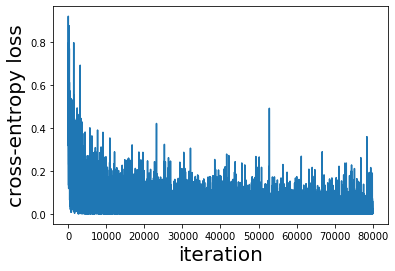

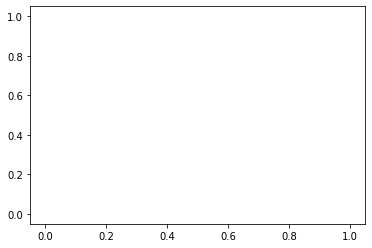

In [7]:
plt.figure()
plt.plot(range(len(history_trainingloss)), history_trainingloss)
plt.xlabel("iteration", fontsize=20)
plt.ylabel("cross-entropy loss", fontsize=20)
plt.show()
plt.figure()
plt.plot(range(len(history_testloss)), history_testloss)
plt.show()

# Evaluation Phase

statcollector created.
 loading initial bigchunks, please wait ....
     bigchunk 0 from 5, please wait ...

     bigchunk 1 from 5, please wait ...

     bigchunk 2 from 5, please wait ...

     bigchunk 3 from 5, please wait ...

     bigchunk 4 from 5, please wait ...

The initial loading of bigchunks took 25.51319122314453 seconds.
self.num_calls_to_getflagfinished = 1

 numstats in [0 , 77],     num zeros = 19


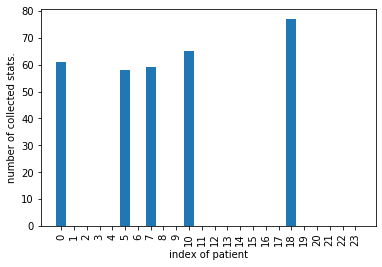

self.num_calls_to_getflagfinished = 2

 numstats in [0 , 101],     num zeros = 18


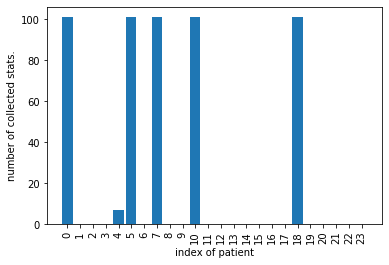

 got 10 stats
self.num_calls_to_getflagfinished = 3

 numstats in [0 , 101],     num zeros = 17


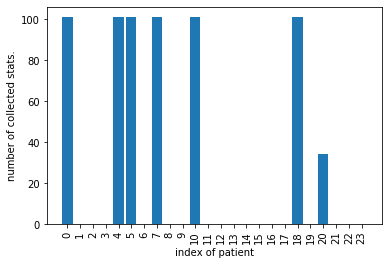

self.num_calls_to_getflagfinished = 4

 numstats in [0 , 162],     num zeros = 17


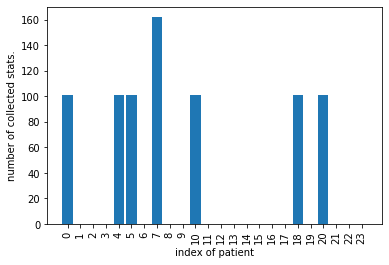

self.num_calls_to_getflagfinished = 5

 numstats in [0 , 202],     num zeros = 17


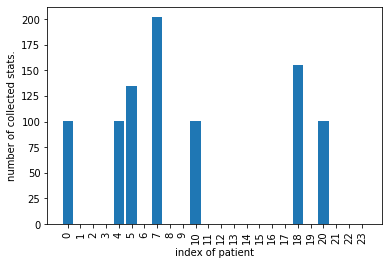

self.num_calls_to_getflagfinished = 6

 numstats in [0 , 202],     num zeros = 17


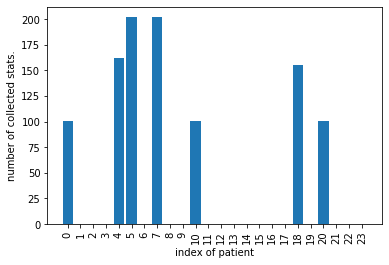

self.num_calls_to_getflagfinished = 7

 numstats in [0 , 202],     num zeros = 17


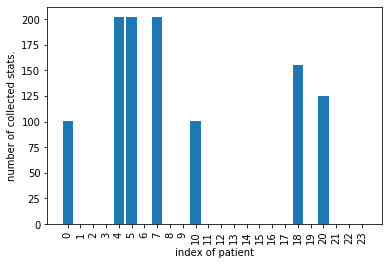

self.num_calls_to_getflagfinished = 8

 numstats in [0 , 202],     num zeros = 16


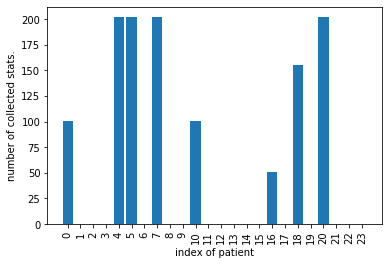

 got 20 stats
self.num_calls_to_getflagfinished = 9

 numstats in [0 , 202],     num zeros = 15


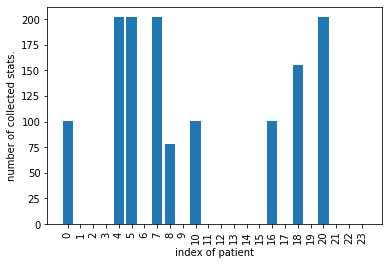

self.num_calls_to_getflagfinished = 10

 numstats in [0 , 202],     num zeros = 14


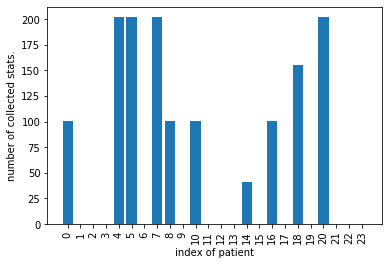

self.num_calls_to_getflagfinished = 11

 numstats in [0 , 202],     num zeros = 14


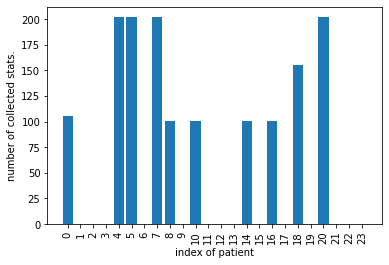

self.num_calls_to_getflagfinished = 12

 numstats in [0 , 202],     num zeros = 14


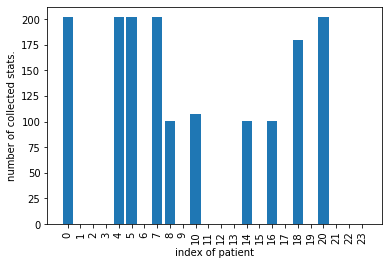

self.num_calls_to_getflagfinished = 13

 numstats in [0 , 303],     num zeros = 14


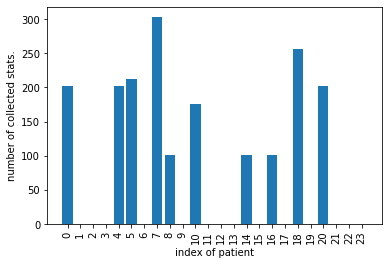

 got 30 stats
self.num_calls_to_getflagfinished = 14

 numstats in [0 , 303],     num zeros = 14


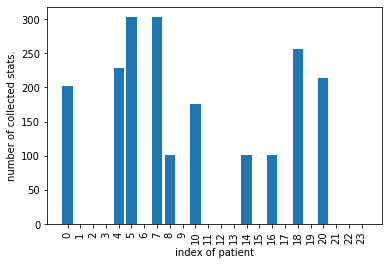

self.num_calls_to_getflagfinished = 15

 numstats in [0 , 303],     num zeros = 14


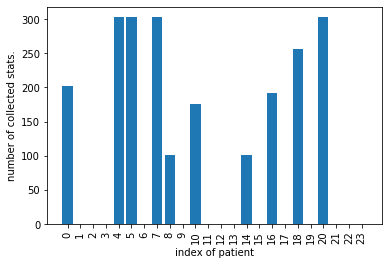

self.num_calls_to_getflagfinished = 16

 numstats in [0 , 303],     num zeros = 14


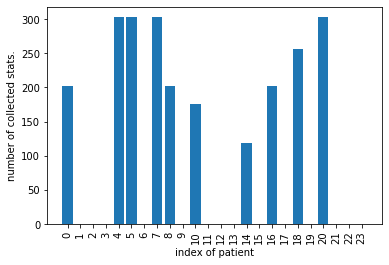

self.num_calls_to_getflagfinished = 17

 numstats in [0 , 303],     num zeros = 13


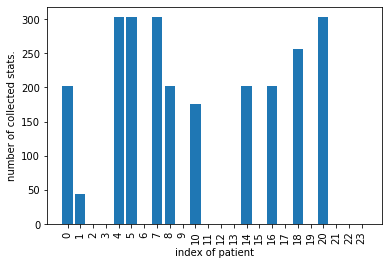

 got 40 stats
self.num_calls_to_getflagfinished = 18

 numstats in [0 , 303],     num zeros = 12


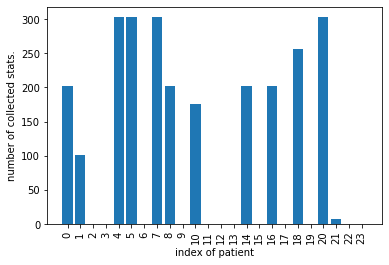

self.num_calls_to_getflagfinished = 19

 numstats in [0 , 303],     num zeros = 10


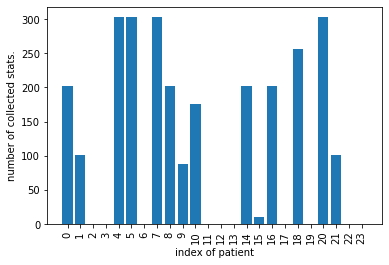

self.num_calls_to_getflagfinished = 20

 numstats in [0 , 303],     num zeros = 9


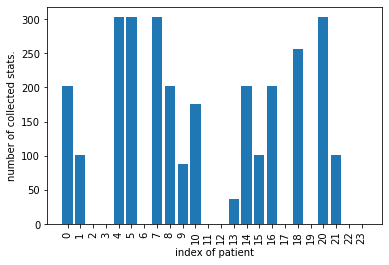

self.num_calls_to_getflagfinished = 21

 numstats in [0 , 303],     num zeros = 7


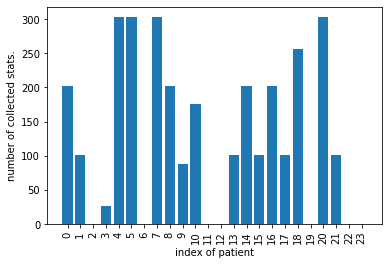

 got 50 stats
self.num_calls_to_getflagfinished = 22

 numstats in [0 , 303],     num zeros = 5


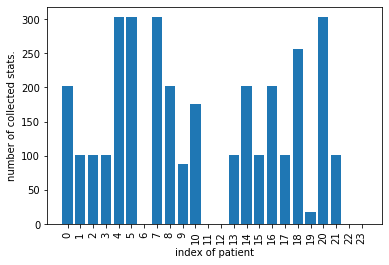

self.num_calls_to_getflagfinished = 23

 numstats in [0 , 303],     num zeros = 4


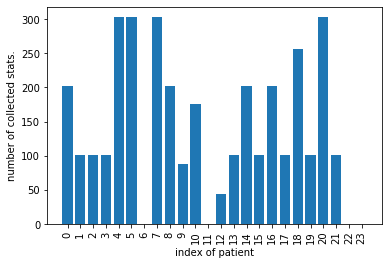

self.num_calls_to_getflagfinished = 24

 numstats in [0 , 303],     num zeros = 2


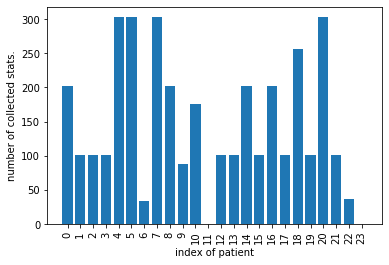

self.num_calls_to_getflagfinished = 25

 numstats in [10 , 303],     num zeros = 0


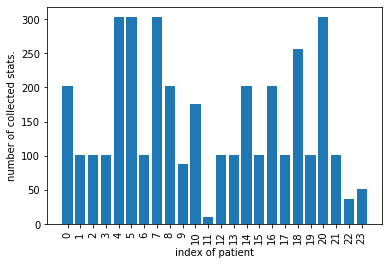

 got 60 stats
self.num_calls_to_getflagfinished = 26

 numstats in [37 , 303],     num zeros = 0


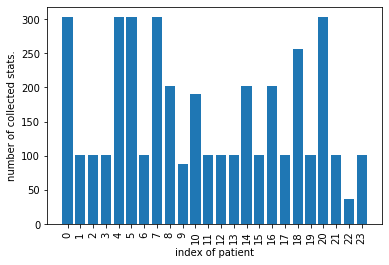

self.num_calls_to_getflagfinished = 27

 numstats in [37 , 309],     num zeros = 0


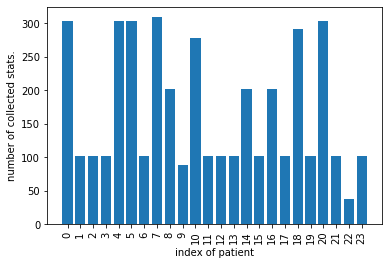

self.num_calls_to_getflagfinished = 28

 numstats in [37 , 404],     num zeros = 0


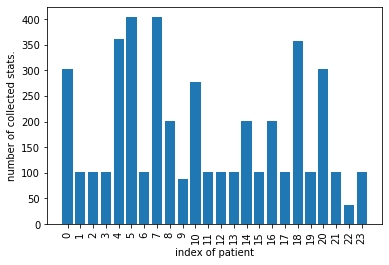

 got 70 stats
self.num_calls_to_getflagfinished = 29

 numstats in [37 , 404],     num zeros = 0


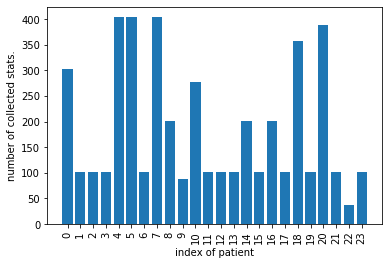

self.num_calls_to_getflagfinished = 30

 numstats in [37 , 404],     num zeros = 0


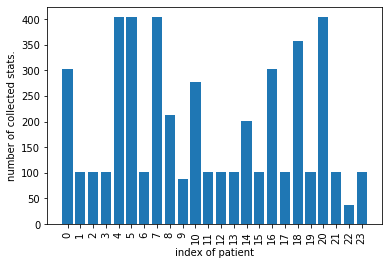

self.num_calls_to_getflagfinished = 31

 numstats in [37 , 404],     num zeros = 0


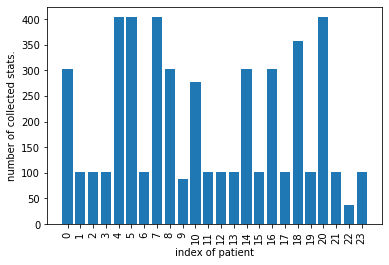

self.num_calls_to_getflagfinished = 32

 numstats in [37 , 404],     num zeros = 0


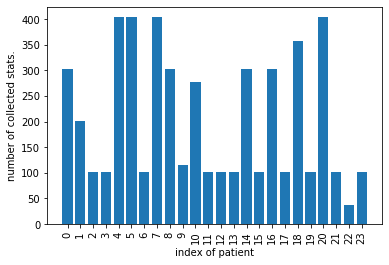

 got 80 stats
self.num_calls_to_getflagfinished = 33

 numstats in [37 , 404],     num zeros = 0


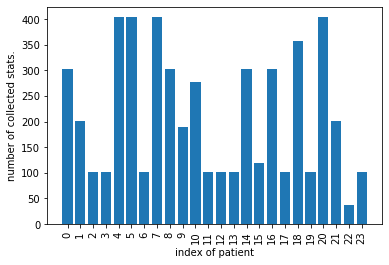

self.num_calls_to_getflagfinished = 34

 numstats in [37 , 404],     num zeros = 0


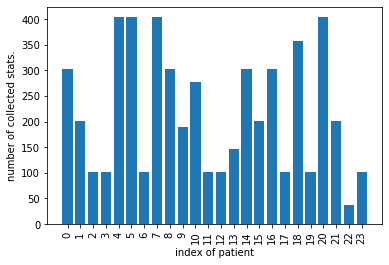

self.num_calls_to_getflagfinished = 35

 numstats in [37 , 404],     num zeros = 0


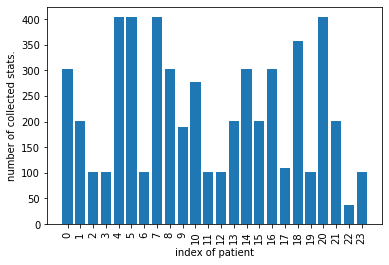

self.num_calls_to_getflagfinished = 36

 numstats in [37 , 404],     num zeros = 0


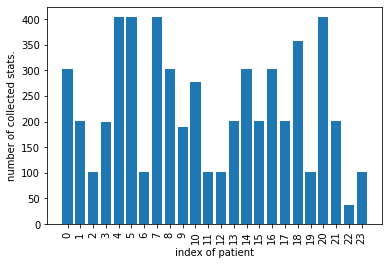

self.num_calls_to_getflagfinished = 37

 numstats in [37 , 404],     num zeros = 0


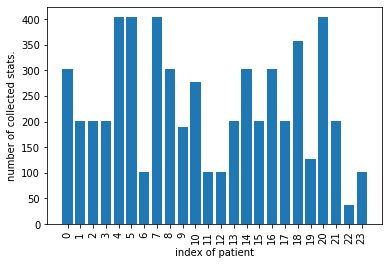

 got 90 stats
self.num_calls_to_getflagfinished = 38

 numstats in [101 , 404],     num zeros = 0


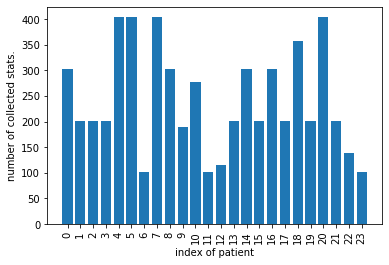

self.num_calls_to_getflagfinished = 39

 numstats in [101 , 404],     num zeros = 0


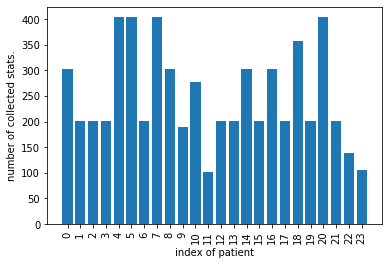

self.num_calls_to_getflagfinished = 40

 numstats in [133 , 404],     num zeros = 0


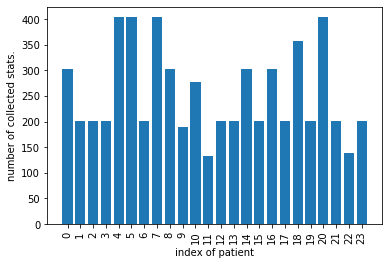

self.num_calls_to_getflagfinished = 41

 numstats in [138 , 404],     num zeros = 0


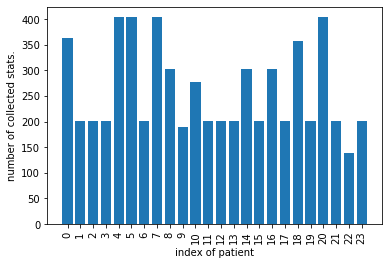

self.num_calls_to_getflagfinished = 42

 numstats in [138 , 404],     num zeros = 0


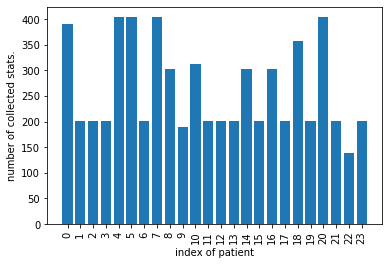

 got 100 stats
self.num_calls_to_getflagfinished = 43

 numstats in [138 , 479],     num zeros = 0


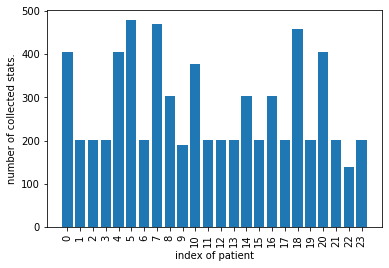

self.num_calls_to_getflagfinished = 44

 numstats in [138 , 500],     num zeros = 0


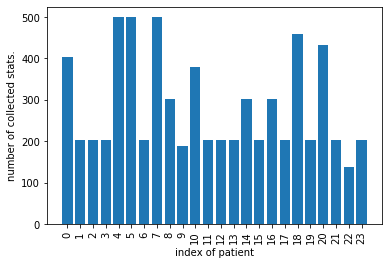

self.num_calls_to_getflagfinished = 45

 numstats in [138 , 500],     num zeros = 0


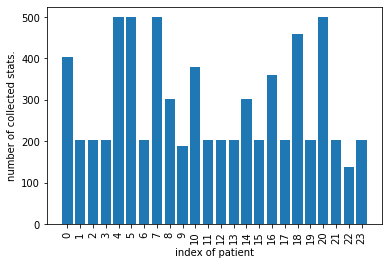

 got 110 stats
self.num_calls_to_getflagfinished = 46

 numstats in [138 , 500],     num zeros = 0


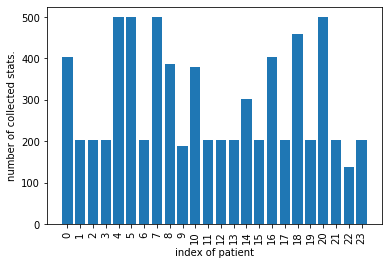

self.num_calls_to_getflagfinished = 47

 numstats in [138 , 500],     num zeros = 0


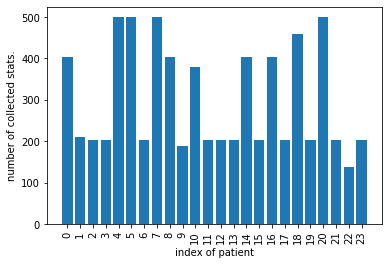

self.num_calls_to_getflagfinished = 48

 numstats in [138 , 500],     num zeros = 0


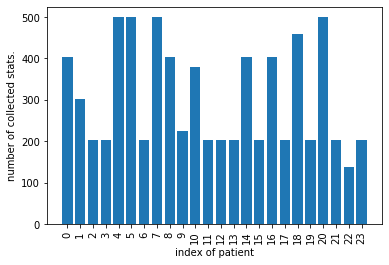

self.num_calls_to_getflagfinished = 49

 numstats in [138 , 500],     num zeros = 0


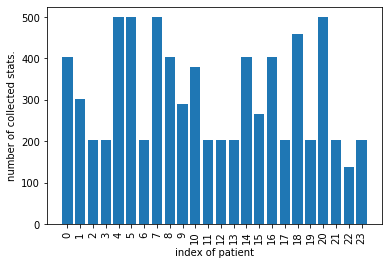

 got 120 stats
self.num_calls_to_getflagfinished = 50

 numstats in [138 , 500],     num zeros = 0


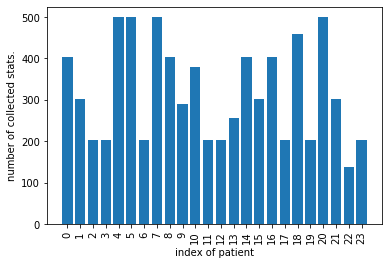

self.num_calls_to_getflagfinished = 51

 numstats in [138 , 500],     num zeros = 0


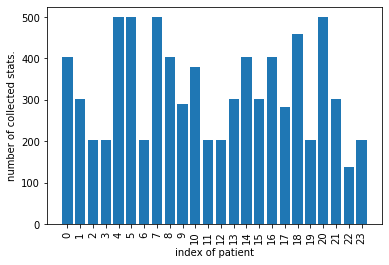

self.num_calls_to_getflagfinished = 52

 numstats in [138 , 500],     num zeros = 0


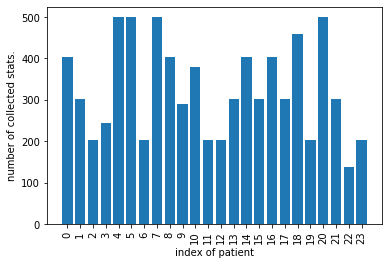

self.num_calls_to_getflagfinished = 53

 numstats in [138 , 500],     num zeros = 0


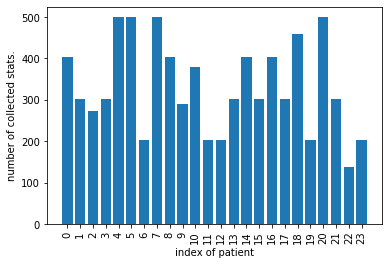

self.num_calls_to_getflagfinished = 54

 numstats in [138 , 500],     num zeros = 0


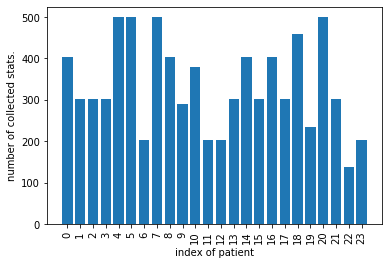

self.num_calls_to_getflagfinished = 55

 numstats in [198 , 500],     num zeros = 0


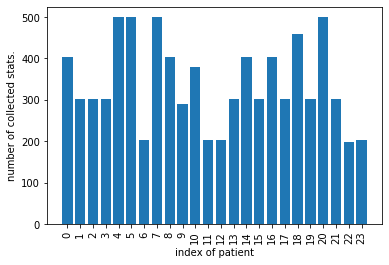

 got 130 stats
self.num_calls_to_getflagfinished = 56

 numstats in [202 , 500],     num zeros = 0


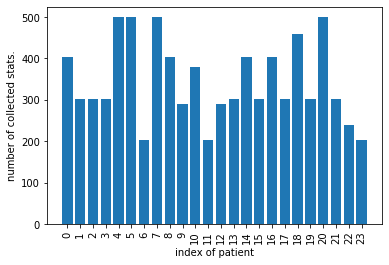

self.num_calls_to_getflagfinished = 57

 numstats in [202 , 500],     num zeros = 0


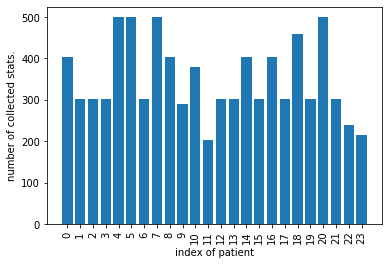

self.num_calls_to_getflagfinished = 58

 numstats in [239 , 500],     num zeros = 0


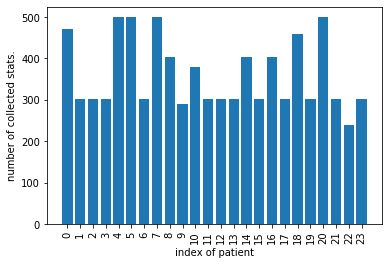

self.num_calls_to_getflagfinished = 59

 numstats in [239 , 500],     num zeros = 0


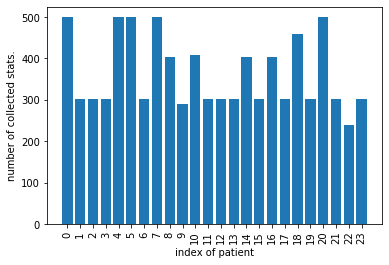

self.num_calls_to_getflagfinished = 60

 numstats in [239 , 500],     num zeros = 0


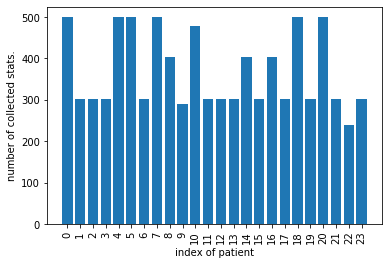

 got 140 stats
self.num_calls_to_getflagfinished = 61

 numstats in [239 , 500],     num zeros = 0


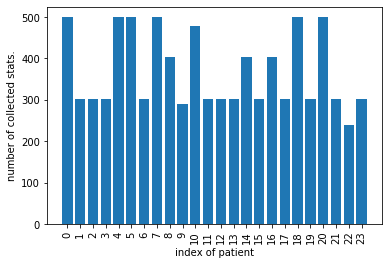

self.num_calls_to_getflagfinished = 62

 numstats in [239 , 500],     num zeros = 0


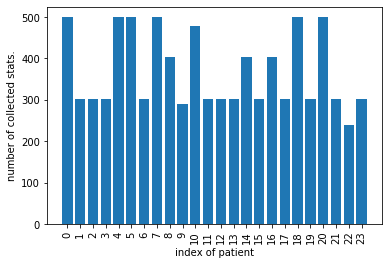

self.num_calls_to_getflagfinished = 63

 numstats in [239 , 500],     num zeros = 0


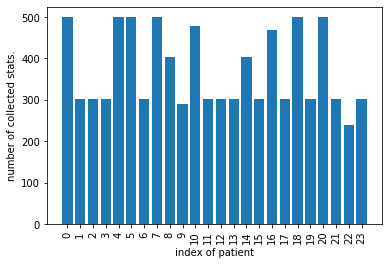

self.num_calls_to_getflagfinished = 64

 numstats in [239 , 500],     num zeros = 0


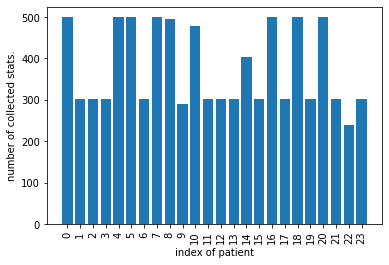

 got 150 stats
self.num_calls_to_getflagfinished = 65

 numstats in [239 , 500],     num zeros = 0


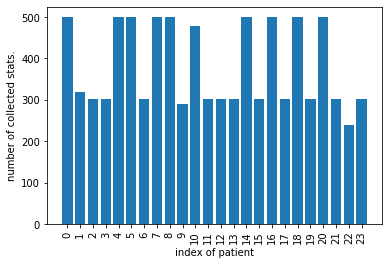

self.num_calls_to_getflagfinished = 66

 numstats in [239 , 500],     num zeros = 0


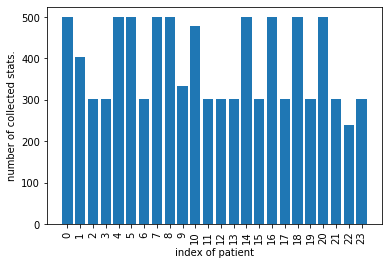

self.num_calls_to_getflagfinished = 67

 numstats in [239 , 500],     num zeros = 0


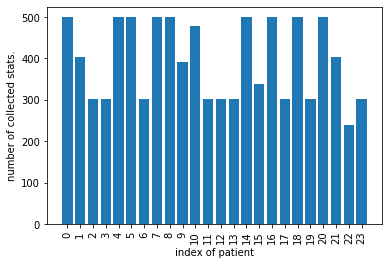

self.num_calls_to_getflagfinished = 68

 numstats in [239 , 500],     num zeros = 0


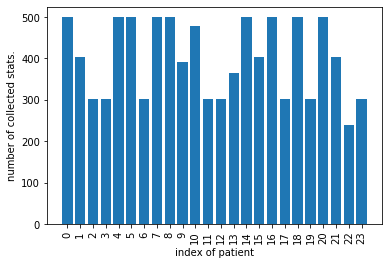

self.num_calls_to_getflagfinished = 69

 numstats in [239 , 500],     num zeros = 0


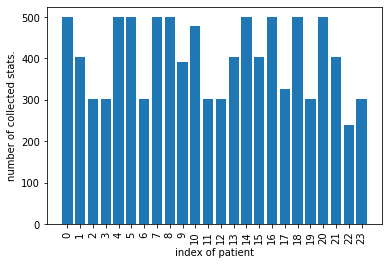

 got 160 stats
self.num_calls_to_getflagfinished = 70

 numstats in [239 , 500],     num zeros = 0


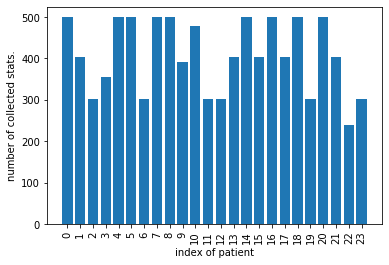

self.num_calls_to_getflagfinished = 71

 numstats in [239 , 500],     num zeros = 0


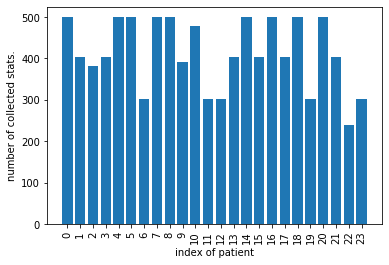

self.num_calls_to_getflagfinished = 72

 numstats in [243 , 500],     num zeros = 0


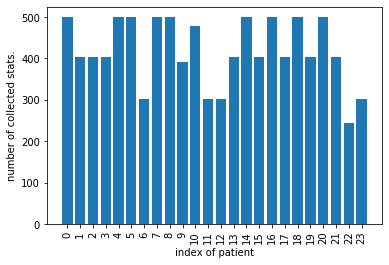

self.num_calls_to_getflagfinished = 73

 numstats in [303 , 500],     num zeros = 0


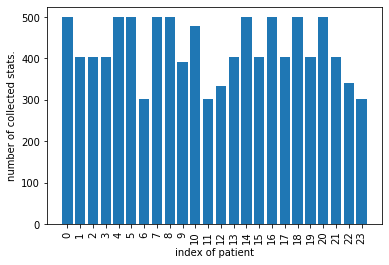

self.num_calls_to_getflagfinished = 74

 numstats in [303 , 500],     num zeros = 0


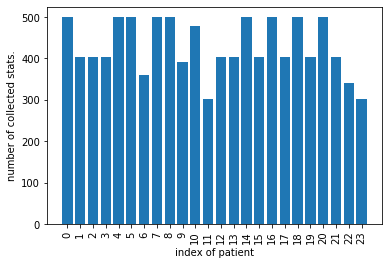

 got 170 stats
self.num_calls_to_getflagfinished = 75

 numstats in [340 , 500],     num zeros = 0


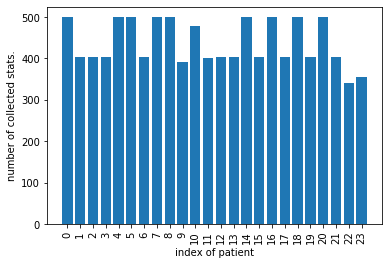

self.num_calls_to_getflagfinished = 76

 numstats in [340 , 500],     num zeros = 0


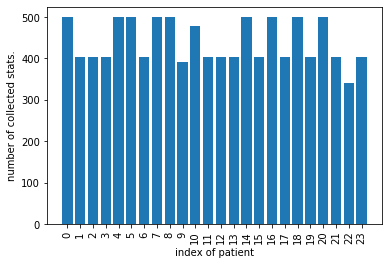

self.num_calls_to_getflagfinished = 77

 numstats in [340 , 500],     num zeros = 0


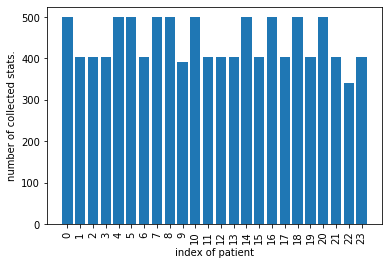

self.num_calls_to_getflagfinished = 78

 numstats in [340 , 500],     num zeros = 0


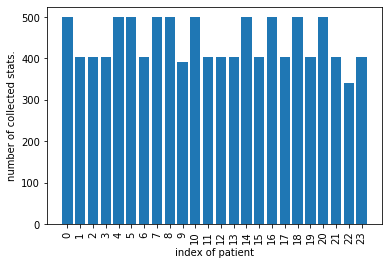

 got 180 stats
self.num_calls_to_getflagfinished = 79

 numstats in [340 , 500],     num zeros = 0


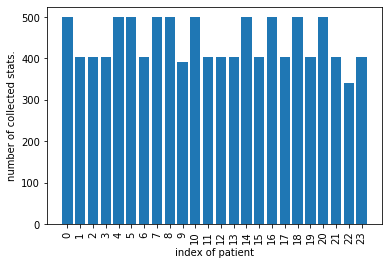

self.num_calls_to_getflagfinished = 80

 numstats in [340 , 500],     num zeros = 0


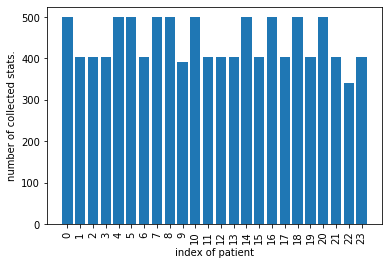

self.num_calls_to_getflagfinished = 81

 numstats in [340 , 500],     num zeros = 0


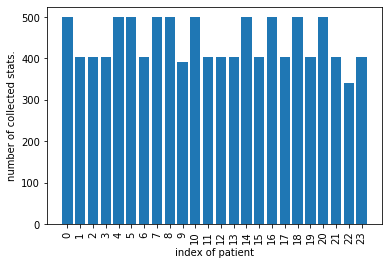

self.num_calls_to_getflagfinished = 82

 numstats in [340 , 500],     num zeros = 0


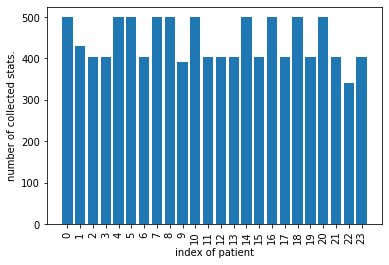

 got 190 stats
self.num_calls_to_getflagfinished = 83

 numstats in [340 , 500],     num zeros = 0


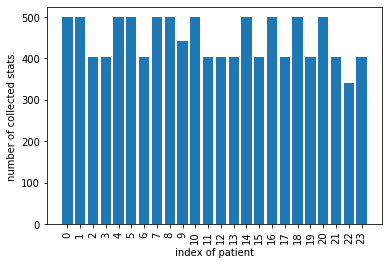

self.num_calls_to_getflagfinished = 84

 numstats in [340 , 500],     num zeros = 0


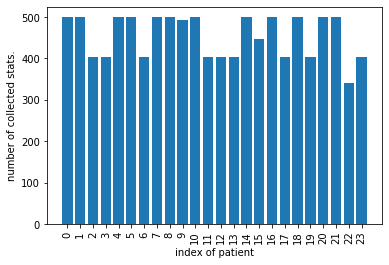

self.num_calls_to_getflagfinished = 85

 numstats in [340 , 500],     num zeros = 0


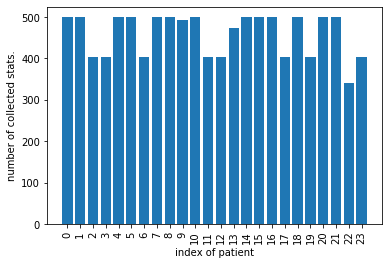

self.num_calls_to_getflagfinished = 86

 numstats in [340 , 500],     num zeros = 0


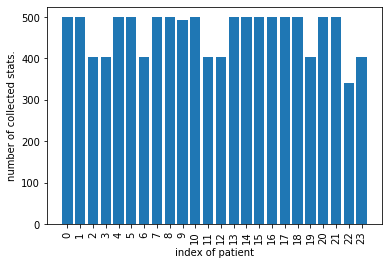

 got 200 stats
self.num_calls_to_getflagfinished = 87

 numstats in [340 , 500],     num zeros = 0


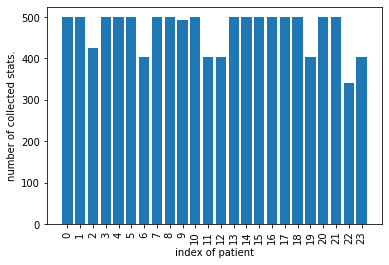

self.num_calls_to_getflagfinished = 88

 numstats in [340 , 500],     num zeros = 0


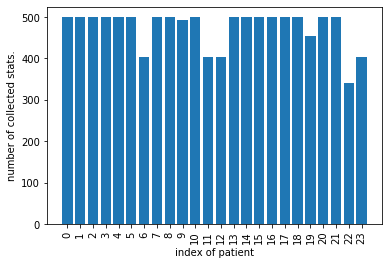

self.num_calls_to_getflagfinished = 89

 numstats in [352 , 500],     num zeros = 0


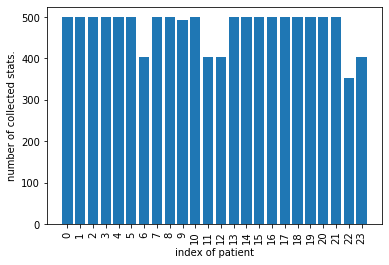

self.num_calls_to_getflagfinished = 90

 numstats in [404 , 500],     num zeros = 0


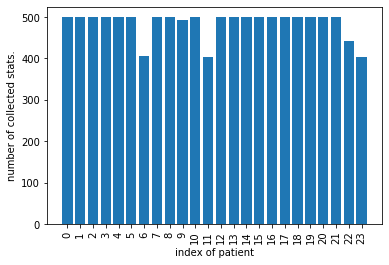

self.num_calls_to_getflagfinished = 91

 numstats in [404 , 500],     num zeros = 0


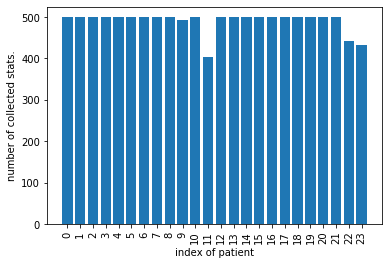

 got 210 stats
self.num_calls_to_getflagfinished = 92

 numstats in [441 , 500],     num zeros = 0


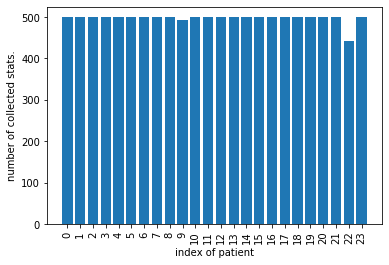

self.num_calls_to_getflagfinished = 93

 numstats in [441 , 500],     num zeros = 0


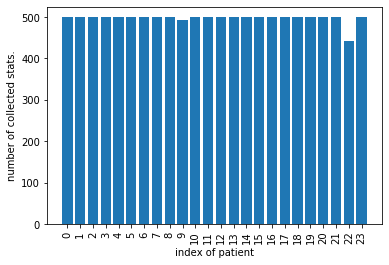

self.num_calls_to_getflagfinished = 94

 numstats in [441 , 500],     num zeros = 0


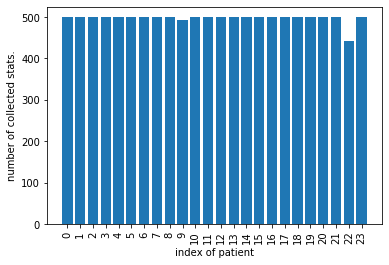

self.num_calls_to_getflagfinished = 95

 numstats in [441 , 500],     num zeros = 0


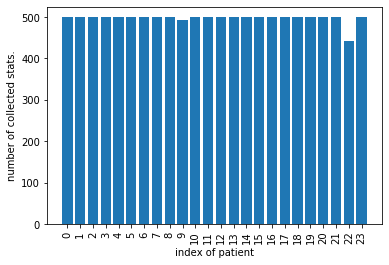

self.num_calls_to_getflagfinished = 96

 numstats in [441 , 500],     num zeros = 0


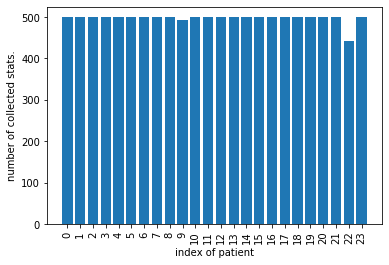

 got 220 stats
self.num_calls_to_getflagfinished = 97

 numstats in [441 , 500],     num zeros = 0


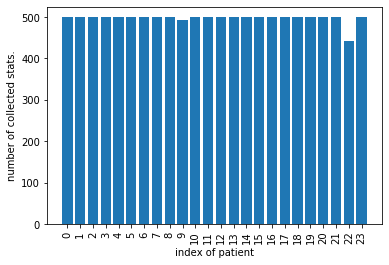

self.num_calls_to_getflagfinished = 98

 numstats in [441 , 500],     num zeros = 0


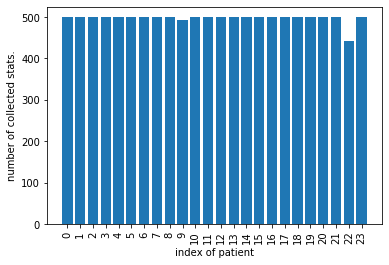

self.num_calls_to_getflagfinished = 99

 numstats in [441 , 500],     num zeros = 0


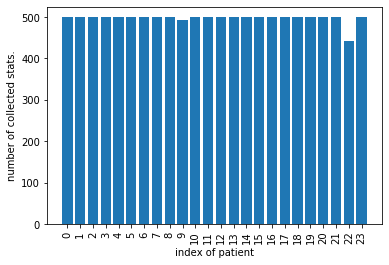

self.num_calls_to_getflagfinished = 100

 numstats in [441 , 500],     num zeros = 0


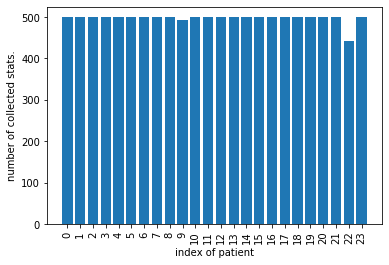

self.num_calls_to_getflagfinished = 101

 numstats in [441 , 500],     num zeros = 0


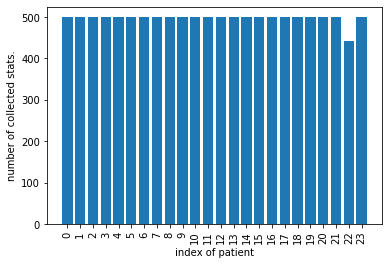

 got 230 stats
self.num_calls_to_getflagfinished = 102

 numstats in [441 , 500],     num zeros = 0


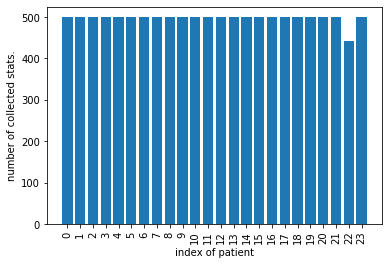

self.num_calls_to_getflagfinished = 103

 numstats in [441 , 500],     num zeros = 0


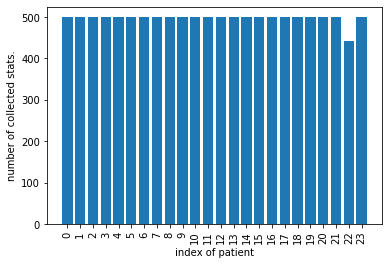

self.num_calls_to_getflagfinished = 104

 numstats in [441 , 500],     num zeros = 0


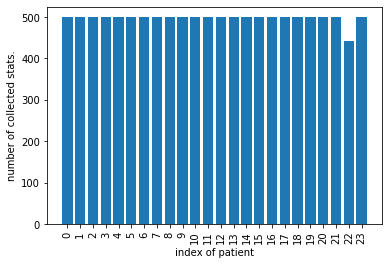

self.num_calls_to_getflagfinished = 105

 numstats in [441 , 500],     num zeros = 0


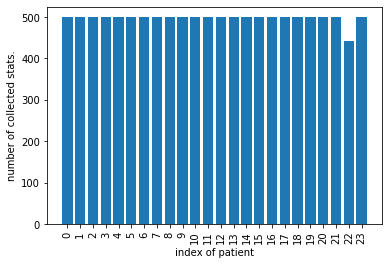

 got 240 stats
self.num_calls_to_getflagfinished = 106

 numstats in [441 , 500],     num zeros = 0


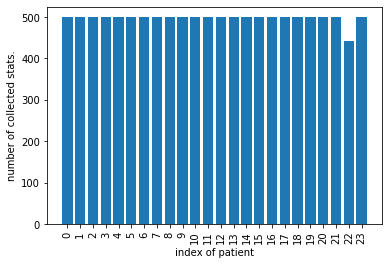

self.num_calls_to_getflagfinished = 107

 numstats in [500 , 500],     num zeros = 0


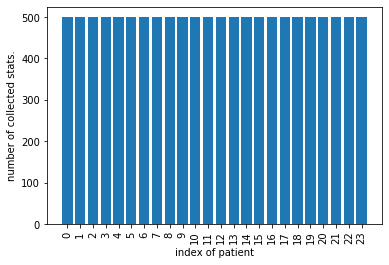

In [8]:
tfms = torchvision.transforms.ToTensor()
const_global_info = {
    "mode_trainortest":"test",
    "width_bigchunk":2000,
    "heigth_bigchunk":2000,
    "width_smallchunk":224*2,
    "heigth_smallchunk":224*2,
    "num_bigchunkloaders":5,
    "maxlength_queue_smallchunk":100,
    "maxlength_queue_lightdl":10000,
    "interval_resched": 5,
    "core-assignment":{"lightdl":None,
                       "smallchunkloaders":None,
                       "bigchunkloaders":None}
}
#TODO:change the dataset from val_ds to test_ds or whole_dataset
dl_of_statcollector = warwickher2.DLWithInTurnSched(
                              dataset=test_ds,\
                              type_bigchunkloader=warwickher2.WSIRandomBigchunkLoader,\
                              type_smallchunkcollector=warwickher2.WSIRandomSmallchunkCollector,\
                              const_global_info=const_global_info,\
                              batch_size=64, tfms=tfms,\
                              flag_grabqueue_onunsched = False
                           ) 
statcollector = warwickher2.WarwickHER2StatCollector(
                                module_pipeline=model, device=device,\
                                lightdl=dl_of_statcollector,\
                                str_collectortype = "accum",\
                                flag_visualizestats=False
                               )
print("statcollector created.")
statcollector.start_collecting()
time.sleep(10) #to make sure that the data from subprocesses is transmitted
dict_patient_to_stats = statcollector.get_finalstats()

In [9]:
#compute dict_patient_to_avgencodeddescriptor ====================
dict_patient_to_avgencodeddescriptor = {}
for patient in dict_patient_to_stats.keys():
    if(dict_patient_to_stats[patient] != None):
#         print(dict_patient_to_stats[patient]["sum_encoded_descriptors"].shape)
        avgh_of_patient = dict_patient_to_stats[patient]["sum_encoded_descriptors"]
                #[200 x 14 x 14]
        avgh_of_patient = np.sum(avgh_of_patient, 1) #[200x14]
        avgh_of_patient = np.sum(avgh_of_patient, 1) #[200]
        avgh_of_patient = avgh_of_patient / dict_patient_to_stats[patient]["count"]
        avgh_of_patient = avgh_of_patient/\
                    (dict_patient_to_stats[patient]["sum_encoded_descriptors"].shape[1]*\
                     dict_patient_to_stats[patient]["sum_encoded_descriptors"].shape[2])
        dict_patient_to_avgencodeddescriptor[patient] = avgh_of_patient
    else:
        dict_patient_to_avgencodeddescriptor[patient] = None

#comput dict_patient_to_prob ========  
dict_patient_to_prob = {}
for patient in dict_patient_to_stats.keys():
    if(dict_patient_to_stats[patient] != None):
        avgh_of_patient = dict_patient_to_avgencodeddescriptor[patient] #[100]
        with torch.no_grad():
            tensor_hofpatient = torch.from_numpy(avgh_of_patient).float()\
                                .unsqueeze(0).unsqueeze(-1).unsqueeze(-1).to(device)
            prob_of_patient = model.module_stg4(tensor_hofpatient).cpu().numpy()[:,:,0,0]
            dict_patient_to_prob[patient] = prob_of_patient
all_probs, all_her2score, all_predy, all_color = [], [], [], []
for patient in dict_patient_to_prob.keys():
    all_probs.append(dict_patient_to_prob[patient].flatten())
    all_her2score.append(float(patient.dict_records["Her2score"]))
    all_predy.append(np.argmax(dict_patient_to_prob[patient].flatten()))
    print(all_probs[-1])
    print(all_predy[-1])
    print("\n\n")

[-4.338313   -0.22690414  4.109364   -9.034402  ]
2



[-3.741425  -0.7157853  2.1892366 -8.703729 ]
2



[-3.4228885  -2.7309237   0.06821216 -8.123703  ]
2



[-1.4528327 -2.7408729 -4.1206317 -5.8447227]
0



[-1.1037507  0.5390347 -3.5145874 -6.4315004]
1



[-1.9619112  1.6589261 -4.7550235 -5.456499 ]
1



[-1.3356365  1.2716104 -3.1333764 -7.736137 ]
1



[-5.5811577   0.56767374  0.33544314 -6.278656  ]
1



[-3.8579593  6.1881447 -2.1274943 -7.3070316]
1



[-1.3967161 -4.0622935  2.3216693 -6.9067016]
2



[-2.8993115 -2.493055   1.6194552 -9.110243 ]
2



[-4.194461   4.741894  -0.1990898 -5.7743683]
1



[-5.8070784  0.9207842  7.284713  -2.2864351]
2



[-3.862734    0.45916602  2.3674166  -2.839353  ]
2



[-4.632213   1.3312485  4.458085  -2.1314979]
2



[-4.428044   5.500357   1.3474259 -6.1329494]
1



[-1.1481538 -6.0240893  3.8999584 -3.1660423]
2



[-4.458006  -4.5549073 10.650178  -0.7196645]
2



[ -3.3880372 -12.973984    8.315776    9.791412 ]
3



[-3.33927  

In [10]:
conf_matrix = warwickher2.confusion_matrix(
                    all_predy, [int(u) for u in all_her2score]
                  )
points_per_wsi = warwickher2.warwickHer2_challengepoints(
                    all_predy, [int(u) for u in all_her2score]
                  )


In [11]:
print("confusion matrix = \n {}".format(conf_matrix))

confusion matrix = 
 [[1. 2. 3. 0.]
 [0. 4. 2. 0.]
 [0. 1. 5. 0.]
 [0. 0. 3. 3.]]


In [12]:
print("points = {}".format(points_per_wsi*34))

points = 435.625
